In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [12]:
data_tomato_price = pd.read_csv("data/data_tomato_price.csv")
data_tomato_price.head()

,date,tomato_price
0,2015-01-02,0.62
1,2015-01-09,0.33
2,2015-01-16,0.34
3,2015-01-23,0.33
4,2015-01-30,0.33


In [13]:
#I modified DataFrame to adapt to Prophet: the prophet package expects input as a dataframe with the first column indicating time and 
# the second indicating the time series we wish to forecast
df_prophet = data_tomato_price.rename(columns={'date': 'ds', 'tomato_price': 'y'})
df_prophet.head()

,ds,y
0,2015-01-02,0.62
1,2015-01-09,0.33
2,2015-01-16,0.34
3,2015-01-23,0.33
4,2015-01-30,0.33


In [4]:
# Development of training function: 
#I looked the outliers dates in exploratory data plot, and in the dataset

def train(df):
    outliers = pd.to_datetime(['2015-01-16', '2015-01-30', '2015-02-13', '2015-02-20', '2015-02-27', '2015-03-04', '2015-03-27', \
        '2016-01-01', '2016-01-15', '2016-01-22', '2016-01-29', '2016-03-25', \
        '2017-03-17', '2017-03-24', '2018-02-02', '2018-02-03', '2018-02-16', '2018-02-23', \
        '2018-03-16', '2018-03-23', '2018-03-30', '2018-09-21', '2018-09-28', \
        '2019-05-04', '2019-05-07', '2019-09-13', '2019-09-20', '2019-12-13', '2019-12-20', '2019-12-27'])
    
    outliers_days = pd.DataFrame({
    'holiday': 'Atypical',
    'ds'     : outliers
    })             
    #Prophet model
    forecast_model = Prophet(growth='linear',  weekly_seasonality=3, yearly_seasonality=3, holidays=outliers_days)
    model = forecast_model.fit(df)
    return model
                   

In [5]:
# Development of prediction function
#ts_test: list of date when I wish the predictions

def predict(model, ts_test):
    #test_date = pd.DataFrame(pd.to_datetime(ts_test), columns=['ds'])
    
    # Predigo, y como prophet trae genera mucha columnas envió solo la columna yhat que es la que tiene la predicción
    #preds = model.predict(ts_test).yhat
    preds = model.predict(ts_test)
    return preds

In [6]:
model = train(df_prophet)
# I get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe
ts_test = model.make_future_dataframe(periods=365)
preds = predict(model, ts_test)
preds[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
621,2020-12-22,0.455807,0.055904,0.871425
622,2020-12-23,0.445943,0.078622,0.851717
623,2020-12-24,0.436146,0.064862,0.829601
624,2020-12-25,0.578166,0.125083,0.970652
625,2020-12-26,0.416808,-0.009441,0.792427


# Interpreting and understanding the model

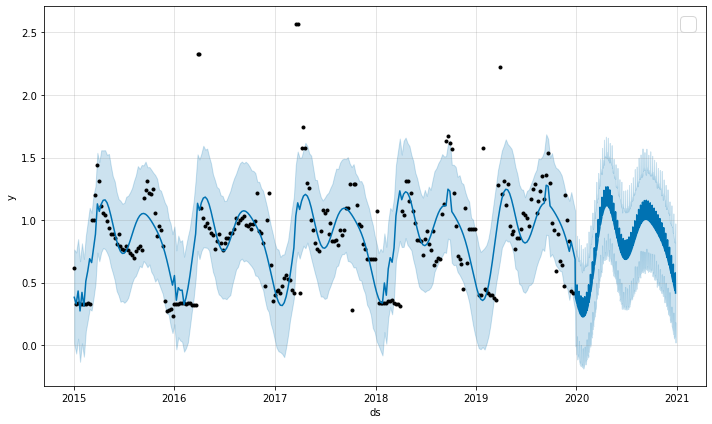

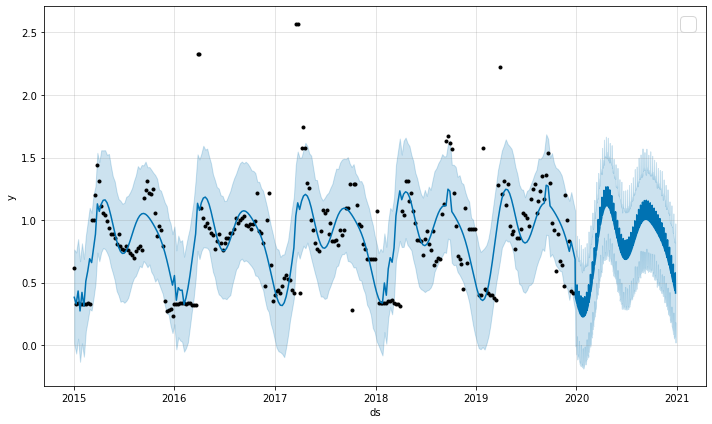

In [7]:
#To see how the model fits existing data and what a forecast over 1 year looks like.

# we can now study the fit of the model - in order to do so, we need to creat another df

df_dates = model.make_future_dataframe(periods=365, 
                                                include_history=True)
model_predictions = model.predict(df_dates)

plot_pred = model.plot(model_predictions)
plt.legend(loc='best', fontsize=20)
plot_pred

 In the plot, the black dots correspond to the observed tomato price each week. The dark blue line (labeled 'yhat') corresponds to the estimated tomato price on the estimated model. Finally, the light blue lines correspond to the 80% ¿? confidence interval for the models predictions.  

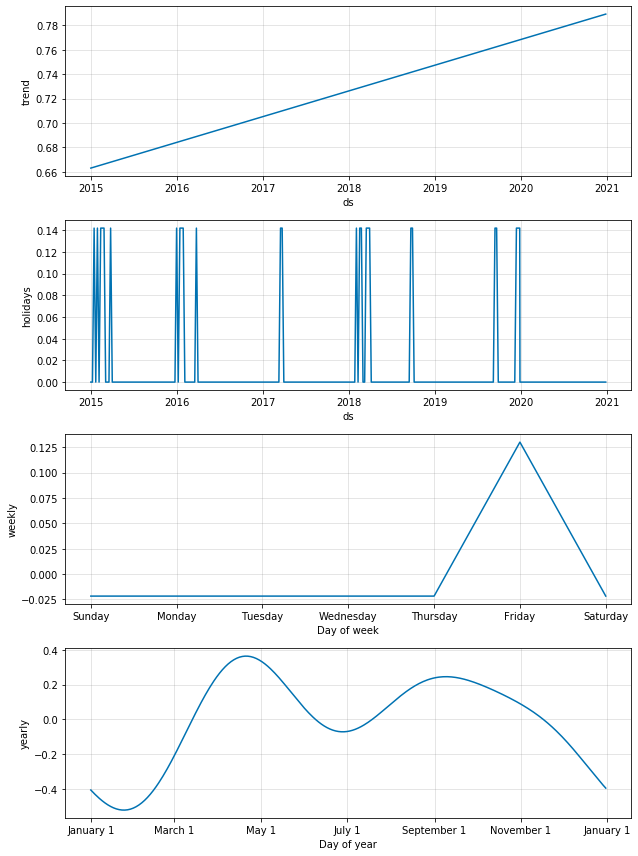

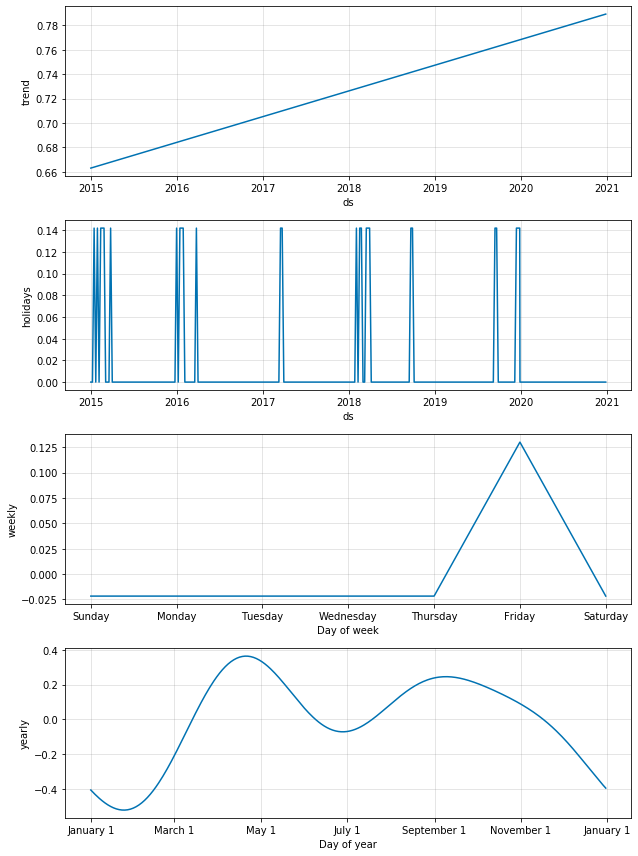

In [8]:
model.plot_components(model_predictions, 
                               uncertainty=False)

# Prophet Diagnostics

In [9]:
#Here, Prophet only identified a downward trend with no seasonality.
#Now, let’s evaluate performance of the model by calculating its mean absolute percentage error (MAPE) 
#and mean absolute error (MAE):

#Prophet includes functionality for time series cross validation to measure forecast error using historical data
#This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up 
#to that cutoff point. We can then compare the forecasted values to the actual values.
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-01-06 00:00:00 and 2018-12-27 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-13,0.194122,-0.108271,0.502391,0.44,2017-01-06
1,2017-01-20,0.180956,-0.120874,0.490870,0.42,2017-01-06
2,2017-01-27,0.201099,-0.118586,0.507804,0.47,2017-01-06
3,2017-02-03,0.254572,-0.057788,0.548281,0.54,2017-01-06
4,2017-02-10,0.338650,0.038123,0.655363,0.56,2017-01-06


In [10]:
#These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). 
#By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head()


,horizon,mse,rmse,mae,mape,coverage
0,36 days,0.125543,0.354321,0.232264,0.338418,0.84
1,37 days,0.120623,0.347309,0.225575,0.332535,0.88
2,39 days,0.120048,0.346480,0.223320,0.338456,0.88
3,41 days,0.102020,0.319405,0.204775,0.326798,0.92
4,42 days,0.101557,0.318679,0.202643,0.327039,0.92


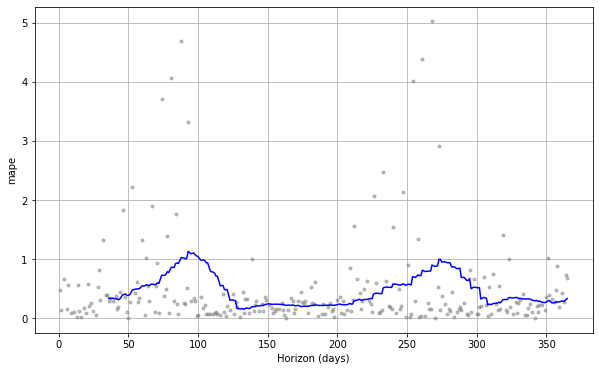

In [11]:
#Cross validation performance metrics can be visualized with plot_cross_validation_metric, 
#here shown for MAPE. Dots show the absolute percent error for each prediction in df_cv. 
#The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. 
#We see for this forecast that errors around 5% are typical for predictions one month into the future, 
#and that errors increase up to around 11% for predictions that are a year out
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mape')

The size of the rolling window in the figure can be changed with the optional argument rolling_window, 
which specifies the proportion of forecasts to use in each rolling window. 
The default is 0.1, corresponding to 10% of rows from df_cv included in each window; 
increasing this will lead to a smoother average curve in the figure.

The initial period should be long enough to capture all of the components of the model, 
in particular seasonalities and extra regressors: at least a year for yearly seasonality, 
at least a week for weekly seasonality, etc.